# Assimilate more proxies

This tutorial demonstrates how to assimilate more proxies than just corals.

## Test data preparation

To go through this tutorial, please prepare test data following the steps:
1. Download the test case named "PAGES2k_CCSM4_GISTEMP" with this [link](https://drive.google.com/drive/folders/1UGn-LNd_tGSjPUKa52E6ffEM-ms2VD-N?usp=sharing).
2. Create a directory named "testcases" in the same directory where this notebook sits.
3. Put the unzipped direcotry "PAGES2k_CCSM4_GISTEMP" into "testcases".

Below, we first load some useful packages, including our `LMRt`.

In [1]:
%load_ext autoreload
%autoreload 2

import LMRt
import os
import numpy as np
import pandas as pd
import xarray as xr

## Load and modify configurations

We will first load the given example YAML file, which is set to reconstruct the temperature field only.
We then modify specific items to set it to assimilate proxy types including:
+ `coral.d18O`
+ `coral.SrCa`
+ `coral.calc`
+ `tree.MXD`
+ `tree.TRW`
+ `ice.d18O`
+ `ice.dD`
+ `ice.melt`

In [2]:
job = LMRt.ReconJob()
job.load_configs(cfg_path='./testcases/PAGES2k_CCSM4_GISTEMP/configs.yml', verbose=True)

LMRt: job.load_configs() >>> loading reconstruction configurations from: ./testcases/PAGES2k_CCSM4_GISTEMP/configs.yml
LMRt: job.load_configs() >>> job.configs created
LMRt: job.load_configs() >>> job.configs["job_dirpath"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon
LMRt: job.load_configs() >>> /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon created
{'anom_period': [1951, 1980],
 'job_dirpath': '/Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon',
 'job_id': 'LMRt_quickstart',
 'obs_path': {'tas': './data/obs/gistemp1200_ERSSTv4.nc'},
 'obs_varname': {'tas': 'tempanomaly'},
 'prior_path': {'tas': './data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc'},
 'prior_regrid_ntrunc': 42,
 'prior_season': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'prior_varname': {'tas': 'TREFHT'},
 'proxy_frac': 0.75,
 'proxydb_path': './data/proxy/pages2k_dataset.pkl',
 'psm_calib_period': [1850, 2

We need to modify the `ptype_psm` and `ptype_season` to include more proxy types.
Moreover, we need to modify the `prior_path` and the `prior_varname` in the configurations to include more variables as the prior, as well as `obs_path` and `obs_varname` to include more variables of instrumental observations for the PSM calibration for `tree.TRW`.
We also modify the `job_dirpath` to save the results to a different location.

In [3]:
job.configs['job_dirpath'] = './testcases/PAGES2k_CCSM4_GISTEMP/recon_more_proxies'

job.configs['ptype_psm'] = {
    'coral.d18O': 'linear',
    'coral.SrCa': 'linear',
    'coral.calc': 'linear',
    'tree.MXD': 'linear',
    'tree.TRW': 'bilinear',  # the PSM for tree-ring width is bivariate linear regression
    'ice.d18O': 'linear',
    'ice.dD': 'linear',
    'ice.melt': 'linear',
}

job.configs['ptype_season'] = {
    'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # annual
    'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # annual
    'coral.calc': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # annual
    'tree.MXD': [
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5]
    ],  # multiple possible seasonalities
    'tree.TRW': [
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5]
    ],  # multiple possible seasonalities
    'ice.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # annual
    'ice.dD': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # annual
    'ice.melt': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # annual
}

# we will need the precipitation prior for forwarding the tree.TRW PSM
job.configs['prior_path'] = {
    'tas': './data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc',
    'pr': './data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.PRECT.085001-184912.nc',
}

# prior_varname indicates the variable names in the given netCDF files of the prior
job.configs['prior_varname'] = {
    'tas': 'TREFHT',
    'pr': 'PRECT',
}

# we will need the precipitation prior for forwarding the tree.TRW PSM
job.configs['obs_path'] = {
    'tas': './data/obs/gistemp1200_ERSSTv4.nc',
    'pr': './data/obs/GPCC_precip.mon.flux.1x1.v6.nc',
}

# prior_varname indicates the variable names in the given netCDF files of the obs
job.configs['obs_varname'] = {
    'tas': 'tempanomaly',
    'pr': 'precip',
}

## Run the reconstruction using the high-level workflow

In [4]:
%%time
job.prepare(verbose=True)

LMRt: job.load_proxydb() >>> job.configs["proxydb_path"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/proxy/pages2k_dataset.pkl
LMRt: job.load_proxydb() >>> 692 records loaded
LMRt: job.load_proxydb() >>> job.proxydb created
LMRt: job.filter_proxydb() >>> filtering proxy records according to: ['coral.d18O', 'coral.SrCa', 'coral.calc', 'tree.MXD', 'tree.TRW', 'ice.d18O', 'ice.dD', 'ice.melt']
LMRt: job.filter_proxydb() >>> 547 records remaining
LMRt: job.seasonalize_proxydb() >>> seasonalizing proxy records according to: {'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.calc': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.MXD': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11

/Users/fzhu/Github/LMRt/LMRt/utils.py:243: RuntimeWarning: Mean of empty slice
  tmp = np.nanmean(var[inds, ...], axis=0)


LMRt: job.seasonalize_ds_for_psm() >>> Seasonalizing variables from prior with season: [3, 4, 5, 6, 7, 8]
LMRt: job.seasonalize_ds_for_psm() >>> Seasonalizing variables from prior with season: [6, 7, 8, 9, 10, 11]
LMRt: job.seasonalize_ds_for_psm() >>> Seasonalizing variables from prior with season: [-12, 1, 2]
LMRt: job.seasonalize_ds_for_psm() >>> Seasonalizing variables from prior with season: [-9, -10, -11, -12, 1, 2]
LMRt: job.seasonalize_ds_for_psm() >>> Seasonalizing variables from prior with season: [-12, 1, 2, 3, 4, 5]


Searching nearest location:   2%|▏         | 11/547 [00:00<00:04, 108.43it/s]

LMRt: job.seasonalize_ds_for_psm() >>> job.seasonalized_prior created


Searching nearest location: 100%|██████████| 547/547 [00:04<00:00, 121.51it/s]


LMRt: job.proxydb.find_nearest_loc() >>> job.proxydb.prior_lat_idx & job.proxydb.prior_lon_idx created
LMRt: job.proxydb.get_var_from_ds() >>> job.proxydb.records[pid].prior_time & job.proxydb.records[pid].prior_value created
LMRt: job.seasonalize_ds_for_psm() >>> job.configs["ptype_season"] = {'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.calc': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.MXD': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'ice.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.dD': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.melt': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
LMRt: job.seasonalize_ds_for_psm() >>> Sea

Searching nearest location:   2%|▏         | 10/547 [00:00<00:05, 99.27it/s]

LMRt: job.seasonalize_ds_for_psm() >>> job.seasonalized_obs created


Calibrating PSM:   0%|          | 0/547 [00:00<?, ?it/s]

LMRt: job.proxydb.find_nearest_loc() >>> job.proxydb.obs_lat_idx & job.proxydb.obs_lon_idx created
LMRt: job.proxydb.get_var_from_ds() >>> job.proxydb.records[pid].obs_time & job.proxydb.records[pid].obs_value created
LMRt: job.proxydb.init_psm() >>> job.proxydb.records[pid].psm initialized
LMRt: job.calibrate_psm() >>> PSM calibration period: [1850, 2015]


Calibrating PSM:  48%|████▊     | 264/547 [01:31<01:07,  4.19it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Forwarding PSM:   4%|▍         | 23/547 [00:00<00:02, 219.89it/s]

LMRt: job.proxydb.calib_psm() >>> job.proxydb.records[pid].psm calibrated
LMRt: job.proxydb.calib_psm() >>> job.proxydb.calibed created


Forwarding PSM: 100%|██████████| 547/547 [00:02<00:00, 252.65it/s]


LMRt: job.proxydb.forward_psm() >>> job.proxydb.records[pid].psm forwarded
LMRt: job.seasonalize_prior() >>> seasonalized prior w/ season [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc
    Shape:  time:1001, lat:96, lon:144

     Name:  pr
   Source:  /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.PRECT.085001-184912.nc
    Shape:  time:1001, lat:96, lon:144
LMRt: job.seasonalize_ds_for_psm() >>> job.prior updated
LMRt: job.regrid_prior() >>> regridded prior
Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc
    Shape:  time:1001, lat:42, lon:63

     Name:

In [5]:
%%time
job.run(recon_seeds=np.arange(1), verbose=True)

LMRt: job.run() >>> job.configs["recon_seeds"] = [0]
LMRt: job.run() >>> job.configs["save_settings"] = {'compress_dict': {'zlib': True, 'least_significant_digit': 1}, 'output_geo_mean': False, 'target_lats': [], 'target_lons': [], 'output_full_ens': False, 'dtype': 32}
LMRt: job.run() >>> job.configs saved to: ./testcases/PAGES2k_CCSM4_GISTEMP/recon_more_proxies/job_configs.yml
LMRt: job.run() >>> seed: 0 | max: 0


KF updating:   0%|          | 2/2001 [00:00<01:58, 16.88it/s]

LMRt: job.run() >>> randomized indices for prior and proxies saved to: ./testcases/PAGES2k_CCSM4_GISTEMP/recon_more_proxies/job_r00_idx.pkl
Proxy Database Overview
-----------------------
     Source:        /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/proxy/pages2k_dataset.pkl
       Size:        406
Proxy types:        {'tree.TRW': 263, 'tree.MXD': 45, 'coral.calc': 5, 'coral.d18O': 49, 'coral.SrCa': 17, 'ice.d18O': 19, 'ice.dD': 7, 'ice.melt': 1}


KF updating: 100%|██████████| 2001/2001 [38:21<00:00,  1.15s/it]


LMRt: job.save_recon() >>> Reconstructed fields saved to: ./testcases/PAGES2k_CCSM4_GISTEMP/recon_more_proxies/job_r00_recon.nc
LMRt: job.run() >>> DONE!
CPU times: user 8h 57min 58s, sys: 39min 17s, total: 9h 37min 16s
Wall time: 39min 18s


Once done, we will get the struture below in the "recon_top" directory:
```
.
├── calibed_psm.pkl
├── job_configs.yml
├── job_r00_idx.pkl
├── job_r00_recon.nc
├── job.pkl
├── obs_loc.pkl
├── prior_loc.pkl
├── seasonalized_obs.pkl
└── seasonalized_prior.pkl
```

We now do a quick preview of the results below.
For more details of the visualization of the results, please move on to the tutorial regarding visualizations.

## A quick preview of the results

In [6]:
# create the res object for reconstruction results
res = LMRt.ReconRes(job.configs['job_dirpath'], verbose=True)

recon_paths: ['./testcases/PAGES2k_CCSM4_GISTEMP/recon_more_proxies/job_r00_recon.nc']
idx_paths: ['./testcases/PAGES2k_CCSM4_GISTEMP/recon_more_proxies/job_r00_idx.pkl']
job_path: ./testcases/PAGES2k_CCSM4_GISTEMP/recon_more_proxies/job.pkl


In [7]:
# get the varialbes from the recon_paths
res.get_vars(['tas', 'nino3.4'], verbose=True)

LMRt: res.get_var() >>> loading variable: tas
LMRt: res.get_var() >>> loading variable: nino3.4
LMRt: res.get_var() >>> res.vars filled w/ varnames: ['tas', 'nino3.4'] and ['year', 'lat', 'lon']


/Users/fzhu/Github/LMRt/LMRt/visual.py:218: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect, extend=extend,


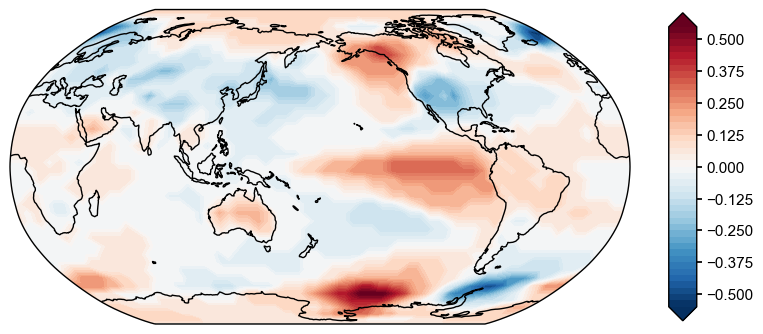

In [8]:
# plot the tas field
fig, ax = res.vars['tas'].field_list[0].plot()

LMRt: res.ReconSeries.validate() >>> valid_period = [1880, 2000]


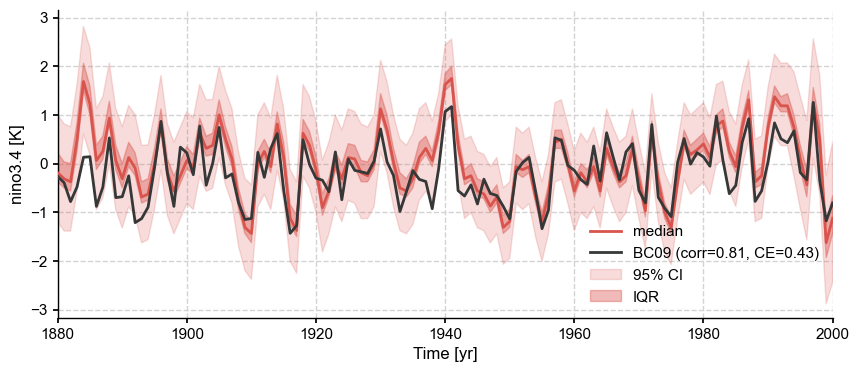

In [9]:
from scipy.io import loadmat

data = loadmat('./testcases/PAGES2k_CCSM4_GISTEMP/data/obs/NINO34_BC09.mat')
syr, eyr = 1873, 2000
nyr = eyr-syr+1
nino34 = np.zeros(nyr)
for i in range(nyr):
    nino34[i] = np.mean(data['nino34'][i*12:12+i*12])
    
target_series = LMRt.Series(time=np.arange(syr, eyr+1), value=nino34, label='BC09')

fig, ax = res.vars['nino3.4'].validate(target_series, verbose=True).plot(xlim=[1880, 2000])